In [1]:
from functools import reduce
import numpy as np
from tqdm.auto import tqdm
import plotly.graph_objects as go
from crater.premade import Classifier, CyclicLearningRate
from cifar10 import Experiment
from cifar10.data import load_batch, make_normalizer, vector_to_image

In [2]:
all_batches = [
    load_batch(f"../data/data_batch_{idx}")
    for idx in [1, 2, 3, 4, 5]
]
all_data = dict(
    features=np.concatenate([batch["features"] for batch in all_batches], axis=0),
    labels=np.concatenate([batch["labels"] for batch in all_batches], axis=0),
)
all_data["features"].shape

(50000, 3072)

In [3]:
test_data = load_batch("../data/test_batch")

In [4]:
split_data = {
    split_name: {
        prop_name: prop[indices]
        for prop_name, prop in all_data.items()
    }
    for split_name, indices in dict(
        train=slice(None, -5000),
        validation=slice(-5000, None),
    ).items()
}
split_data["test"] = test_data

{
    split_name: split["features"].shape
    for split_name, split in split_data.items()
}

{'train': (45000, 3072), 'validation': (5000, 3072), 'test': (10000, 3072)}

# Without batch normalization

## 3-layer network

  0%|          | 0/4500 [00:00<?, ?it/s]

/home/malyvsen/org/education/kth/deep-learning/kth-deep-learning/assignments/crater/operations/exp.py:10: RuntimeWarning:

overflow encountered in exp

/home/malyvsen/org/education/kth/deep-learning/kth-deep-learning/assignments/crater/operations/divide.py:10: RuntimeWarning:

invalid value encountered in true_divide

/home/malyvsen/org/education/kth/deep-learning/kth-deep-learning/assignments/crater/operations/log.py:10: RuntimeWarning:

divide by zero encountered in log

/home/malyvsen/org/education/kth/deep-learning/kth-deep-learning/assignments/crater/operations/multiply.py:9: RuntimeWarning:

invalid value encountered in multiply

/home/malyvsen/org/education/kth/deep-learning/kth-deep-learning/.venv/lib/python3.9/site-packages/numpy/core/_methods.py:47: RuntimeWarning:

overflow encountered in reduce



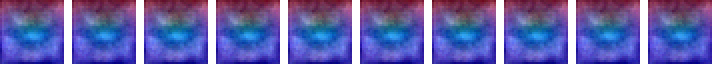

In [10]:
def train(hidden_dims: list, persistence: float, regularization: float = 0.005, batch_size: int = 100):
    return Experiment.run(
        data=split_data,
        classifier=Classifier.from_dims(
            [32 * 32 * 3] + hidden_dims + [10],
            normalize=make_normalizer(split_data["train"]["features"]),
            persistence=persistence,
        ),
        learning_rate=CyclicLearningRate(
            low=1e-5,
            high=1e-1,
            batches_per_cycle=5 * len(split_data["train"]["features"]) // batch_size
        ),
        num_cycles=2,
        measurements_per_cycle=10,
        batch_size=batch_size,
        regularization=regularization,
    )

experiment = train(hidden_dims=[50, 50], persistence=1)
vector_to_image(*experiment.classifier.templates)

In [11]:
experiment.loss_plot

In [12]:
experiment.accuracy_plot

## 9-layer network

In [ ]:
experiment = train(hidden_dims=[50, 30, 20, 20, 10, 10, 10, 10])
vector_to_image(*experiment.classifier.templates)

In [ ]:
experiment.loss_plot

In [ ]:
experiment.accuracy_plot

# With batch normalization

## Search for regularization

In [ ]:
experiments_by_regularization = {
    regularization: regularization_experiment(regularization)
    for regularization in tqdm(10 ** np.linspace(-12, 0, 10))
}

In [ ]:
def regularization_plot():
    return go.Figure(
        layout=dict(
            title="In search of the optimal regularization",
            xaxis_title="Regularization",
            xaxis_type="log",
            yaxis_title="Validation accuracy",
        ),
        data=[
            go.Scatter(
                mode="markers",
                x=list(experiments_by_regularization.keys()),
                y=[experiment.final_accuracy for experiment in experiments_by_regularization.values()],
            )
        ]
    )

regularization_plot()

In [ ]:
for regularization in tqdm(10 ** np.linspace(-5, -3, 10)):
    experiments_by_regularization[regularization] = regularization_experiment(regularization)
    
regularization_plot()

In [ ]:
experiment = Experiment.run(
    data=split_data,
    classifier=Classifier.from_dims(
        [32 * 32 * 3, 50, 10],
        normalize=make_normalizer(split_data["train"]["features"])
    ),
    learning_rate=CyclicLearningRate(
        low=1e-5,
        high=1e-1,
        batches_per_cycle=8 * len(split_data["train"]["features"]) // 100
    ),
    num_cycles=3,
    batch_size=100,
    regularization=max(
        experiments_by_regularization.keys(),
        key=lambda regularization: experiments_by_regularization[regularization].final_accuracy,
    ),
)
vector_to_image(*experiment.classifier.templates)

In [ ]:
experiment.loss_plot

In [ ]:
experiment.accuracy_plot